## 1. Installing

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, mean_squared_error, r2_score, roc_auc_score, roc_curve, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import KFold

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=FutureWarning) 
warnings.filterwarnings("ignore", category=UserWarning) 

%config InlineBackend.figure_format = 'retina'

# to display all columns and rows:
pd.set_option('display.max_columns', None); pd.set_option('display.max_rows', None);  # to display all columns and rows
pd.set_option('display.float_format', lambda x: '%.2f' % x) # The number of numbers that will be shown after the comma.


In [3]:
#Reading the dataset
df = pd.read_csv("diabetes.csv")

In [4]:
df.shape

(768, 9)

In [5]:
df.describe([0.10,0.25,0.50,0.75,0.90,0.95,0.99]).T

,count,mean,std,min,10%,25%,50%,75%,90%,95%,99%,max
Pregnancies,768.00,3.85,3.37,0.00,0.00,1.00,3.00,6.00,9.00,10.00,13.00,17.00
Glucose,768.00,120.89,31.97,0.00,85.00,99.00,117.00,140.25,167.00,181.00,196.00,199.00
BloodPressure,768.00,69.11,19.36,0.00,54.00,62.00,72.00,80.00,88.00,90.00,106.00,122.00
SkinThickness,768.00,20.54,15.95,0.00,0.00,0.00,23.00,32.00,40.00,44.00,51.33,99.00
Insulin,768.00,79.80,115.24,0.00,0.00,0.00,30.50,127.25,210.00,293.00,519.90,846.00
BMI,768.00,31.99,7.88,0.00,23.60,27.30,32.00,36.60,41.50,44.39,50.76,67.10
DiabetesPedigreeFunction,768.00,0.47,0.33,0.08,0.17,0.24,0.37,0.63,0.88,1.13,1.70,2.42
Age,768.00,33.24,11.76,21.00,22.00,24.00,29.00,41.00,51.00,58.00,67.00,81.00
Outcome,768.00,0.35,0.48,0.00,0.00,0.00,0.00,1.00,1.00,1.00,1.00,1.00


In [6]:
df["Outcome"].value_counts()*100/len(df)

0   65.10
1   34.90
Name: Outcome, dtype: float64

In [7]:
df.Outcome.value_counts()

0    500
1    268
Name: Outcome, dtype: int64

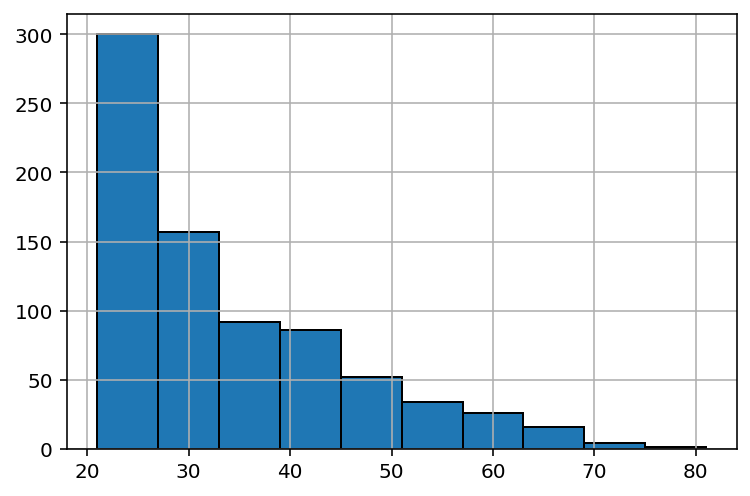

In [8]:
df["Age"].hist(edgecolor = "black");

In [9]:
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [10]:
df[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']] = df[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']].replace(0, np.NaN)

In [11]:
df.isnull().sum()

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

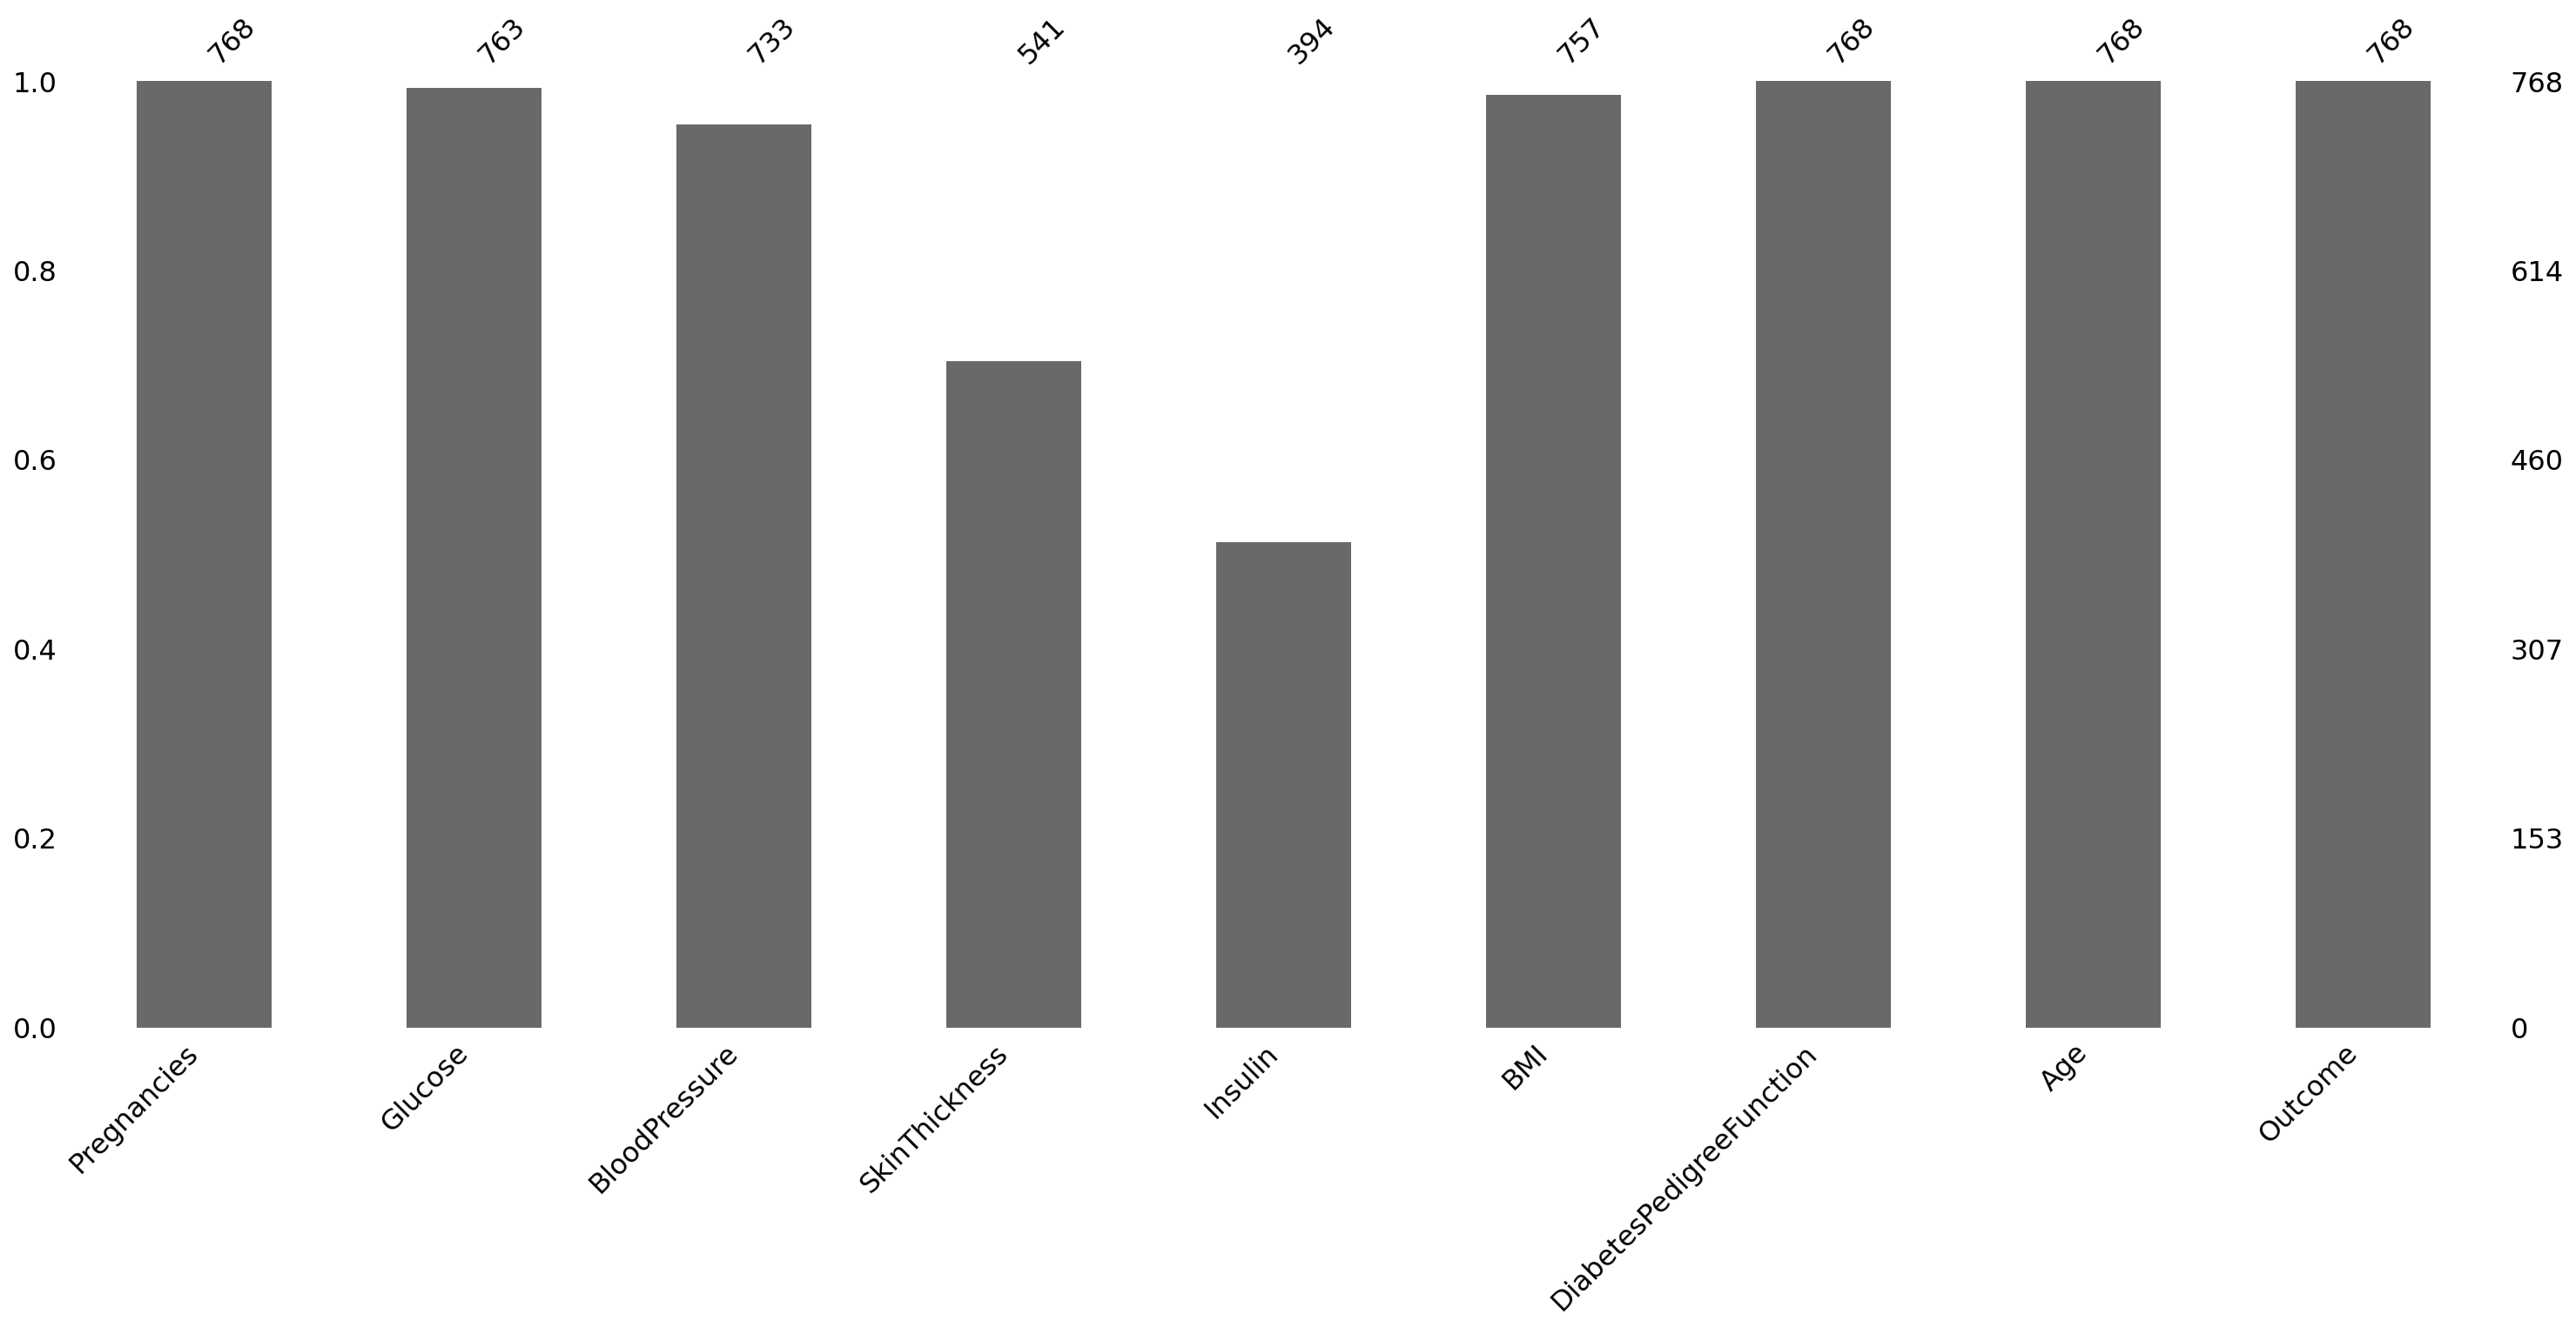

In [13]:
import missingno as msno
msno.bar(df);

In [14]:
def carp(x,y):
    
    z = x*y
    
    return z


In [15]:
carp(4,5)

20

In [16]:
# The missing values will be filled with the median values of each variable.

def median_target(var):   
    
    temp = df[df[var].notnull()]
    
    temp = temp[[var, 'Outcome']].groupby(['Outcome'])[[var]].median().reset_index()
    
    return temp

In [17]:
columns = df.columns

columns = columns.drop("Outcome")

In [18]:
columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age'],
      dtype='object')

In [19]:
median_target('Glucose')

,Outcome,Glucose
0,0,107.00
1,1,140.00


In [20]:
# The values to be given for incomplete observations are given the median value of people who are not sick and the median values of people who are sick.

columns = df.columns

columns = columns.drop("Outcome")

for col in columns:
    
    df.loc[(df['Outcome'] == 0 ) & (df[col].isnull()), col] = median_target(col)[col][0]
    df.loc[(df['Outcome'] == 1 ) & (df[col].isnull()), col] = median_target(col)[col][1]

In [21]:
df.loc[(df['Outcome'] == 0 ) & (df["Pregnancies"].isnull()), "Pregnancies"]

Series([], Name: Pregnancies, dtype: int64)

In [22]:
df[(df['Outcome'] == 0 ) & (df["BloodPressure"].isnull())]

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome


In [23]:
Q1 = df["BloodPressure"].quantile(0.25)
Q3 = df["BloodPressure"].quantile(0.75)
IQR = Q3-Q1
lower = Q1 - 1.5*IQR
upper = Q3 + 1.5*IQR

In [24]:
lower

40.0

In [25]:
upper

104.0

In [26]:
df[(df["BloodPressure"] > upper)].any(axis=None)

True

In [27]:
for feature in df:
    print(feature)

Pregnancies
Glucose
BloodPressure
SkinThickness
Insulin
BMI
DiabetesPedigreeFunction
Age
Outcome


In [28]:
for feature in df:
    
    Q1 = df[feature].quantile(0.05)
    Q3 = df[feature].quantile(0.95)
    IQR = Q3 - Q1
    lower = Q1 - 1.5*IQR
    upper = Q3 + 1.5*IQR
    
    if df[(df[feature] > upper)].any(axis=None):
        print(feature,"yes")
    else:
        print(feature, "no")

Pregnancies no
Glucose no
BloodPressure no
SkinThickness yes
Insulin yes
BMI no
DiabetesPedigreeFunction no
Age no
Outcome no


In [29]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.00,72.00,35.00,169.50,33.60,0.63,50,1
1,1,85.00,66.00,29.00,102.50,26.60,0.35,31,0
2,8,183.00,64.00,32.00,169.50,23.30,0.67,32,1
3,1,89.00,66.00,23.00,94.00,28.10,0.17,21,0
4,0,137.00,40.00,35.00,168.00,43.10,2.29,33,1


In [30]:
df.shape

(768, 9)

In [31]:
# According to BMI, some ranges were determined and categorical variables were assigned.
NewBMI = pd.Series(["Underweight", "Normal", "Overweight", "Obesity 1", "Obesity 2", "Obesity 3"], dtype = "category")

df["NewBMI"] = NewBMI

df.loc[df["BMI"] < 18.5, "NewBMI"] = NewBMI[0]

df.loc[(df["BMI"] > 18.5) & (df["BMI"] <= 24.9), "NewBMI"] = NewBMI[1]
df.loc[(df["BMI"] > 24.9) & (df["BMI"] <= 29.9), "NewBMI"] = NewBMI[2]
df.loc[(df["BMI"] > 29.9) & (df["BMI"] <= 34.9), "NewBMI"] = NewBMI[3]
df.loc[(df["BMI"] > 34.9) & (df["BMI"] <= 39.9), "NewBMI"] = NewBMI[4]
df.loc[df["BMI"] > 39.9 ,"NewBMI"] = NewBMI[5]

In [32]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,NewBMI
0,6,148.00,72.00,35.00,169.50,33.60,0.63,50,1,Obesity 1
1,1,85.00,66.00,29.00,102.50,26.60,0.35,31,0,Overweight
2,8,183.00,64.00,32.00,169.50,23.30,0.67,32,1,Normal
3,1,89.00,66.00,23.00,94.00,28.10,0.17,21,0,Overweight
4,0,137.00,40.00,35.00,168.00,43.10,2.29,33,1,Obesity 3


In [33]:
def set_insulin(row):
    if row["Insulin"] >= 16 and row["Insulin"] <= 166:
        return "Normal"
    else:
        return "Abnormal"     

In [34]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,NewBMI
0,6,148.00,72.00,35.00,169.50,33.60,0.63,50,1,Obesity 1
1,1,85.00,66.00,29.00,102.50,26.60,0.35,31,0,Overweight
2,8,183.00,64.00,32.00,169.50,23.30,0.67,32,1,Normal
3,1,89.00,66.00,23.00,94.00,28.10,0.17,21,0,Overweight
4,0,137.00,40.00,35.00,168.00,43.10,2.29,33,1,Obesity 3


In [35]:
df["NewInsulinScore"] = df.apply(set_insulin, axis=1)

In [36]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,NewBMI,NewInsulinScore
0,6,148.00,72.00,35.00,169.50,33.60,0.63,50,1,Obesity 1,Abnormal
1,1,85.00,66.00,29.00,102.50,26.60,0.35,31,0,Overweight,Normal
2,8,183.00,64.00,32.00,169.50,23.30,0.67,32,1,Normal,Abnormal
3,1,89.00,66.00,23.00,94.00,28.10,0.17,21,0,Overweight,Normal
4,0,137.00,40.00,35.00,168.00,43.10,2.29,33,1,Obesity 3,Abnormal


In [ ]:
#df.drop("NewInsulinScore", inplace = True, axis = 1)
#df.head()

In [37]:
# Some intervals were determined according to the glucose variable and these were assigned categorical variables.
NewGlucose = pd.Series(["Low", "Normal", "Overweight", "Secret", "High"], dtype = "category")

df["NewGlucose"] = NewGlucose

df.loc[df["Glucose"] <= 70, "NewGlucose"] = NewGlucose[0]

df.loc[(df["Glucose"] > 70) & (df["Glucose"] <= 99), "NewGlucose"] = NewGlucose[1]

df.loc[(df["Glucose"] > 99) & (df["Glucose"] <= 126), "NewGlucose"] = NewGlucose[2]

df.loc[df["Glucose"] > 126 ,"NewGlucose"] = NewGlucose[3]

In [38]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,NewBMI,NewInsulinScore,NewGlucose
0,6,148.00,72.00,35.00,169.50,33.60,0.63,50,1,Obesity 1,Abnormal,Secret
1,1,85.00,66.00,29.00,102.50,26.60,0.35,31,0,Overweight,Normal,Normal
2,8,183.00,64.00,32.00,169.50,23.30,0.67,32,1,Normal,Abnormal,Secret
3,1,89.00,66.00,23.00,94.00,28.10,0.17,21,0,Overweight,Normal,Normal
4,0,137.00,40.00,35.00,168.00,43.10,2.29,33,1,Obesity 3,Abnormal,Secret


In [39]:
df = pd.get_dummies(df, columns =["NewBMI","NewInsulinScore", "NewGlucose"], drop_first = True)

In [40]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,NewBMI_Obesity 1,NewBMI_Obesity 2,NewBMI_Obesity 3,NewBMI_Overweight,NewBMI_Underweight,NewInsulinScore_Normal,NewGlucose_Low,NewGlucose_Normal,NewGlucose_Overweight,NewGlucose_Secret
0,6,148.00,72.00,35.00,169.50,33.60,0.63,50,1,1,0,0,0,0,0,0,0,0,1
1,1,85.00,66.00,29.00,102.50,26.60,0.35,31,0,0,0,0,1,0,1,0,1,0,0
2,8,183.00,64.00,32.00,169.50,23.30,0.67,32,1,0,0,0,0,0,0,0,0,0,1
3,1,89.00,66.00,23.00,94.00,28.10,0.17,21,0,0,0,0,1,0,1,0,1,0,0
4,0,137.00,40.00,35.00,168.00,43.10,2.29,33,1,0,0,1,0,0,0,0,0,0,1


In [41]:
categorical_df = df[['NewBMI_Obesity 1','NewBMI_Obesity 2', 'NewBMI_Obesity 3', 'NewBMI_Overweight','NewBMI_Underweight',
                     'NewInsulinScore_Normal','NewGlucose_Low','NewGlucose_Normal', 'NewGlucose_Overweight', 'NewGlucose_Secret']]

In [42]:
y = df["Outcome"]
X = df.drop(["Outcome",'NewBMI_Obesity 1','NewBMI_Obesity 2', 'NewBMI_Obesity 3', 'NewBMI_Overweight','NewBMI_Underweight',
                     'NewInsulinScore_Normal','NewGlucose_Low','NewGlucose_Normal', 'NewGlucose_Overweight', 'NewGlucose_Secret'], axis = 1)
cols = X.columns
index = X.index

In [43]:
y.head()

0    1
1    0
2    1
3    0
4    1
Name: Outcome, dtype: int64

In [44]:
X.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,6,148.00,72.00,35.00,169.50,33.60,0.63,50
1,1,85.00,66.00,29.00,102.50,26.60,0.35,31
2,8,183.00,64.00,32.00,169.50,23.30,0.67,32
3,1,89.00,66.00,23.00,94.00,28.10,0.17,21
4,0,137.00,40.00,35.00,168.00,43.10,2.29,33


In [45]:
cols

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age'],
      dtype='object')

In [46]:
index

RangeIndex(start=0, stop=768, step=1)

In [47]:
from sklearn.preprocessing import RobustScaler
transformer = RobustScaler().fit(X)
X = transformer.transform(X)
X = pd.DataFrame(X, columns = cols, index = index)

In [48]:
X.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,0.60,0.77,0.00,1.00,1.00,0.17,0.67,1.24
1,-0.40,-0.79,-0.38,0.14,0.00,-0.60,-0.06,0.12
2,1.00,1.63,-0.50,0.57,1.00,-0.96,0.78,0.18
3,-0.40,-0.69,-0.38,-0.71,-0.13,-0.43,-0.54,-0.47
4,-0.60,0.49,-2.00,1.00,0.98,1.21,5.01,0.24


In [49]:
X = pd.concat([X, categorical_df], axis = 1)

In [50]:
X.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,NewBMI_Obesity 1,NewBMI_Obesity 2,NewBMI_Obesity 3,NewBMI_Overweight,NewBMI_Underweight,NewInsulinScore_Normal,NewGlucose_Low,NewGlucose_Normal,NewGlucose_Overweight,NewGlucose_Secret
0,0.60,0.77,0.00,1.00,1.00,0.17,0.67,1.24,1,0,0,0,0,0,0,0,0,1
1,-0.40,-0.79,-0.38,0.14,0.00,-0.60,-0.06,0.12,0,0,0,1,0,1,0,1,0,0
2,1.00,1.63,-0.50,0.57,1.00,-0.96,0.78,0.18,0,0,0,0,0,0,0,0,0,1
3,-0.40,-0.69,-0.38,-0.71,-0.13,-0.43,-0.54,-0.47,0,0,0,1,0,1,0,1,0,0
4,-0.60,0.49,-2.00,1.00,0.98,1.21,5.01,0.24,0,0,1,0,0,0,0,0,0,1


LR: 0.847539 (0.032028)
KNN: 0.837235 (0.031427)
CART: 0.838602 (0.026456)
RF: 0.878947 (0.030074)
SVM: 0.848855 (0.035492)
XGB: 0.880297 (0.029243)
LightGBM: 0.879016 (0.037431)


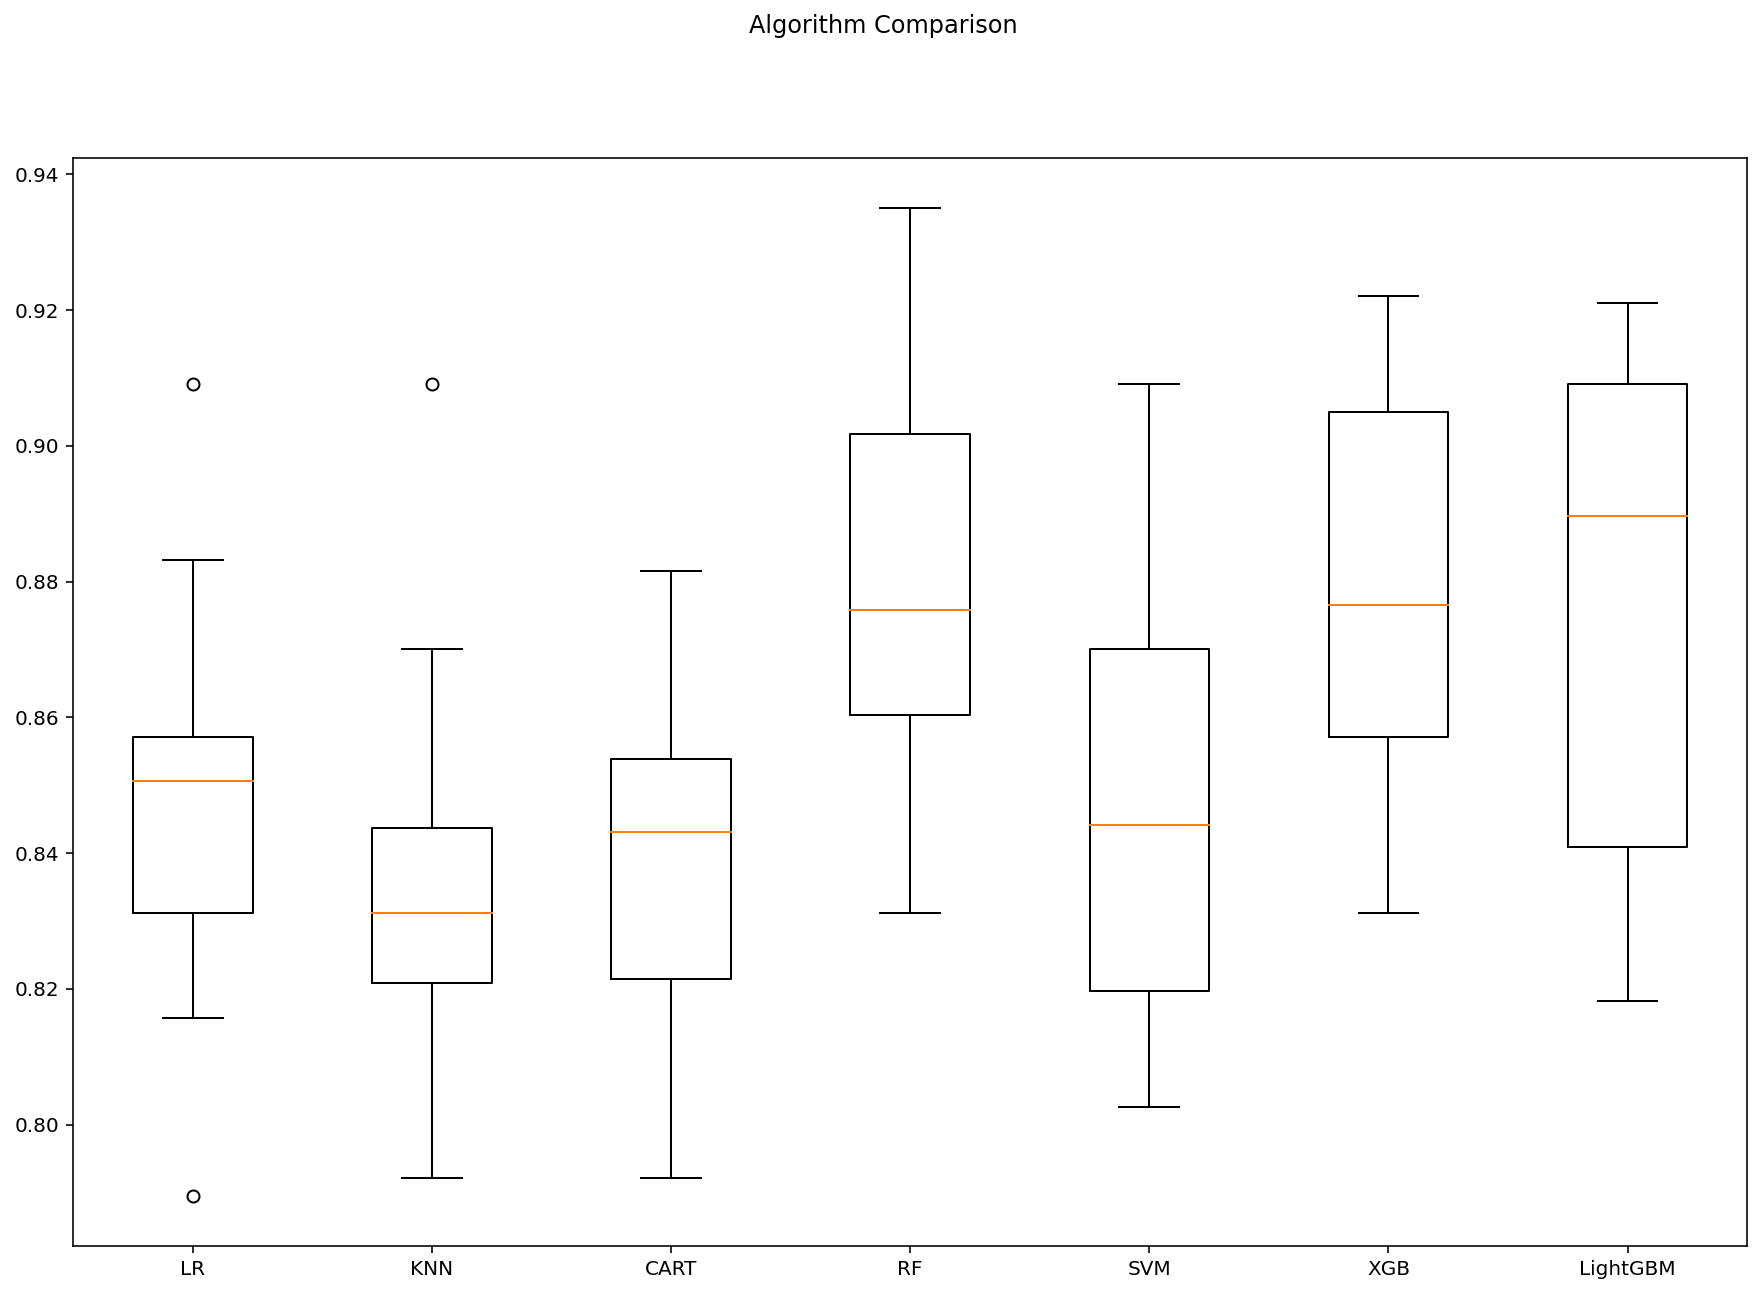

In [52]:
models = []
models.append(('LR', LogisticRegression(random_state = 12345)))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier(random_state = 12345)))
models.append(('RF', RandomForestClassifier(random_state = 12345)))
models.append(('SVM', SVC(gamma='auto', random_state = 12345)))
models.append(('XGB', GradientBoostingClassifier(random_state = 12345)))
models.append(("LightGBM", LGBMClassifier(random_state = 12345)))

# evaluate each model in turn
results = []
names = []

for name, model in models:
    
        kfold = KFold(n_splits = 10)
        
        cv_results = cross_val_score(model, X, y, cv = 10, scoring= "accuracy")
        results.append(cv_results)
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)
        
# boxplot algorithm comparison
fig = plt.figure(figsize=(15,10))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()



In [53]:
rf_params = {"n_estimators" :[100,200,500,1000], 
             "max_features": [3,5,7], 
             "min_samples_split": [2,5,10,30],
            "max_depth": [3,5,8,None]}



In [54]:
rf_model = RandomForestClassifier(random_state = 12345)

In [55]:
gs_cv = GridSearchCV(rf_model, 
                    rf_params,
                    cv = 10,
                    n_jobs = -1,
                    verbose = 2).fit(X, y)


Fitting 10 folds for each of 192 candidates, totalling 1920 fits


In [56]:
gs_cv.best_params_

{'max_depth': None,
 'max_features': 7,
 'min_samples_split': 5,
 'n_estimators': 500}

In [57]:
rf_tuned = RandomForestClassifier(**gs_cv.best_params_)

In [58]:
rf_tuned = rf_tuned.fit(X,y)

In [59]:
cross_val_score(rf_tuned, X, y, cv = 10).mean()

0.8880724538619276

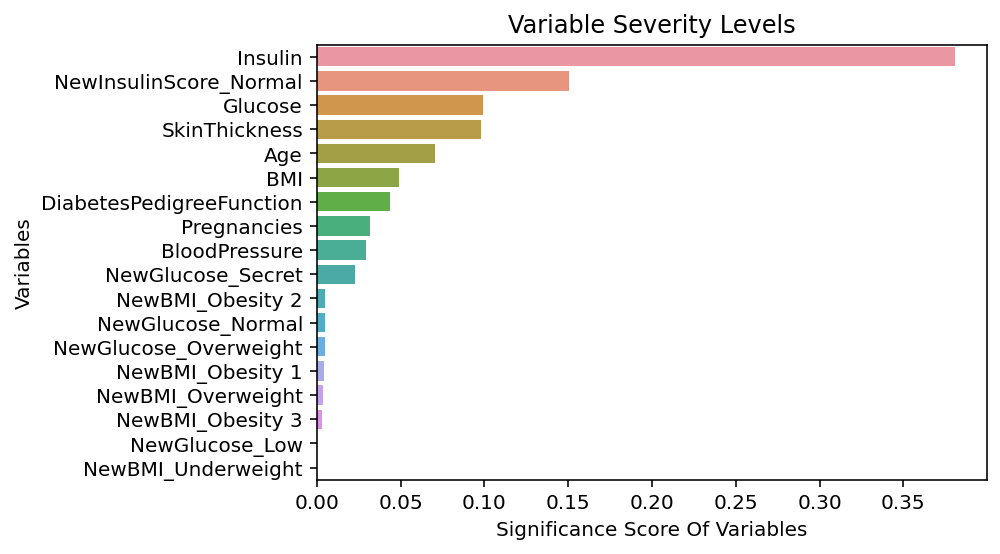

In [60]:
feature_imp = pd.Series(rf_tuned.feature_importances_,
                        index=X.columns).sort_values(ascending=False)

sns.barplot(x=feature_imp, y=feature_imp.index)
plt.xlabel('Significance Score Of Variables')
plt.ylabel('Variables')
plt.title("Variable Severity Levels")
plt.show()

In [61]:
lgbm = LGBMClassifier(random_state = 12345)

In [62]:
lgbm_params = {"learning_rate": [0.01, 0.03, 0.05, 0.1, 0.5],
              "n_estimators": [500, 1000, 1500],
              "max_depth":[3,5,8]}


In [63]:
gs_cv = GridSearchCV(lgbm, 
                     lgbm_params, 
                     cv = 10, 
                     n_jobs = -1, 
                     verbose = 2).fit(X, y)

Fitting 10 folds for each of 45 candidates, totalling 450 fits


In [64]:
gs_cv.best_params_

{'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 1000}

In [65]:
lgbm_tuned = LGBMClassifier(**gs_cv.best_params_).fit(X,y)

In [ ]:
import pickle

pickle.dump(lgbm_tuned, open('lgbm_model.h5','wb'))

In [66]:
cross_val_score(lgbm_tuned, X, y, cv = 10).mean()

0.8959159261790841

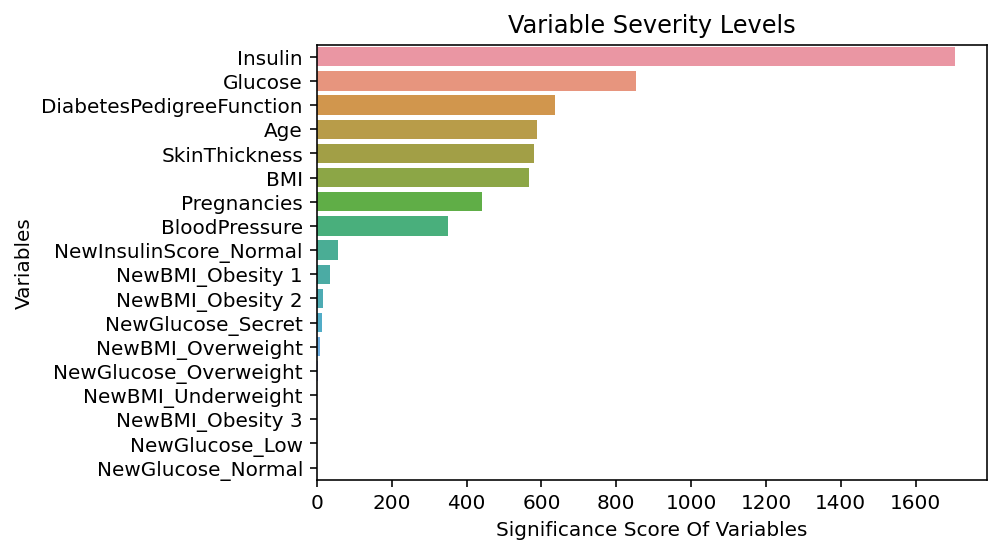

In [67]:
feature_imp = pd.Series(lgbm_tuned.feature_importances_,
                        index=X.columns).sort_values(ascending=False)

sns.barplot(x=feature_imp, y=feature_imp.index)
plt.xlabel('Significance Score Of Variables')
plt.ylabel('Variables')
plt.title("Variable Severity Levels")
plt.show()

In [68]:
xgb = GradientBoostingClassifier(random_state = 12345)

In [69]:
xgb_params = {
    "learning_rate": [0.01, 0.1, 0.2, 1],
    "min_samples_split": np.linspace(0.1, 0.5, 10),
    "max_depth":[3,5,8],
    "subsample":[0.5, 0.9, 1.0],
    "n_estimators": [100,1000]}

In [70]:
xgb_cv_model  = GridSearchCV(xgb,xgb_params, cv = 10, n_jobs = -1, verbose = 2).fit(X, y)

Fitting 10 folds for each of 720 candidates, totalling 7200 fits


In [71]:
xgb_cv_model.best_params_

{'learning_rate': 0.01,
 'max_depth': 8,
 'min_samples_split': 0.1,
 'n_estimators': 1000,
 'subsample': 1.0}

In [72]:
xgb_tuned = GradientBoostingClassifier(**xgb_cv_model.best_params_).fit(X,y)

In [73]:
cross_val_score(xgb_tuned, X, y, cv = 10).mean()

0.898462064251538

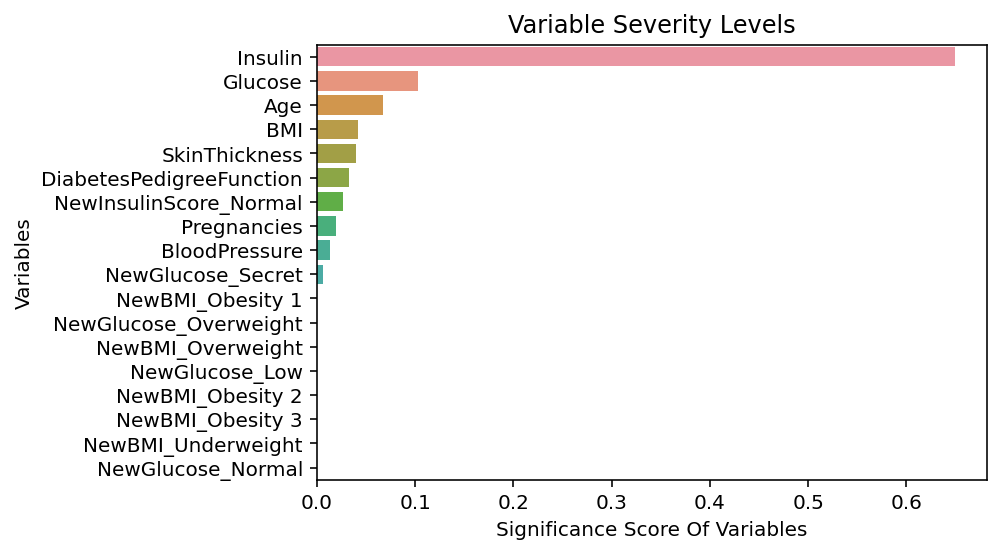

In [74]:
feature_imp = pd.Series(xgb_tuned.feature_importances_,
                        index=X.columns).sort_values(ascending=False)

sns.barplot(x=feature_imp, y=feature_imp.index)
plt.xlabel('Significance Score Of Variables')
plt.ylabel('Variables')
plt.title("Variable Severity Levels")
plt.show()

In [75]:
models = []

models.append(('RF', RandomForestClassifier(random_state = 12345, max_depth = 8, max_features = 7, min_samples_split = 2, n_estimators = 500)))
models.append(('XGB', GradientBoostingClassifier(random_state = 12345, learning_rate = 0.1, max_depth = 5, min_samples_split = 0.1, n_estimators = 100, subsample = 1.0)))
models.append(("LightGBM", LGBMClassifier(random_state = 12345, learning_rate = 0.01,  max_depth = 3, n_estimators = 1000)))

# evaluate each model in turn
results = []
names = []

RF: 0.886791 (0.028298)
XGB: 0.886757 (0.021597)
LightGBM: 0.895916 (0.031116)


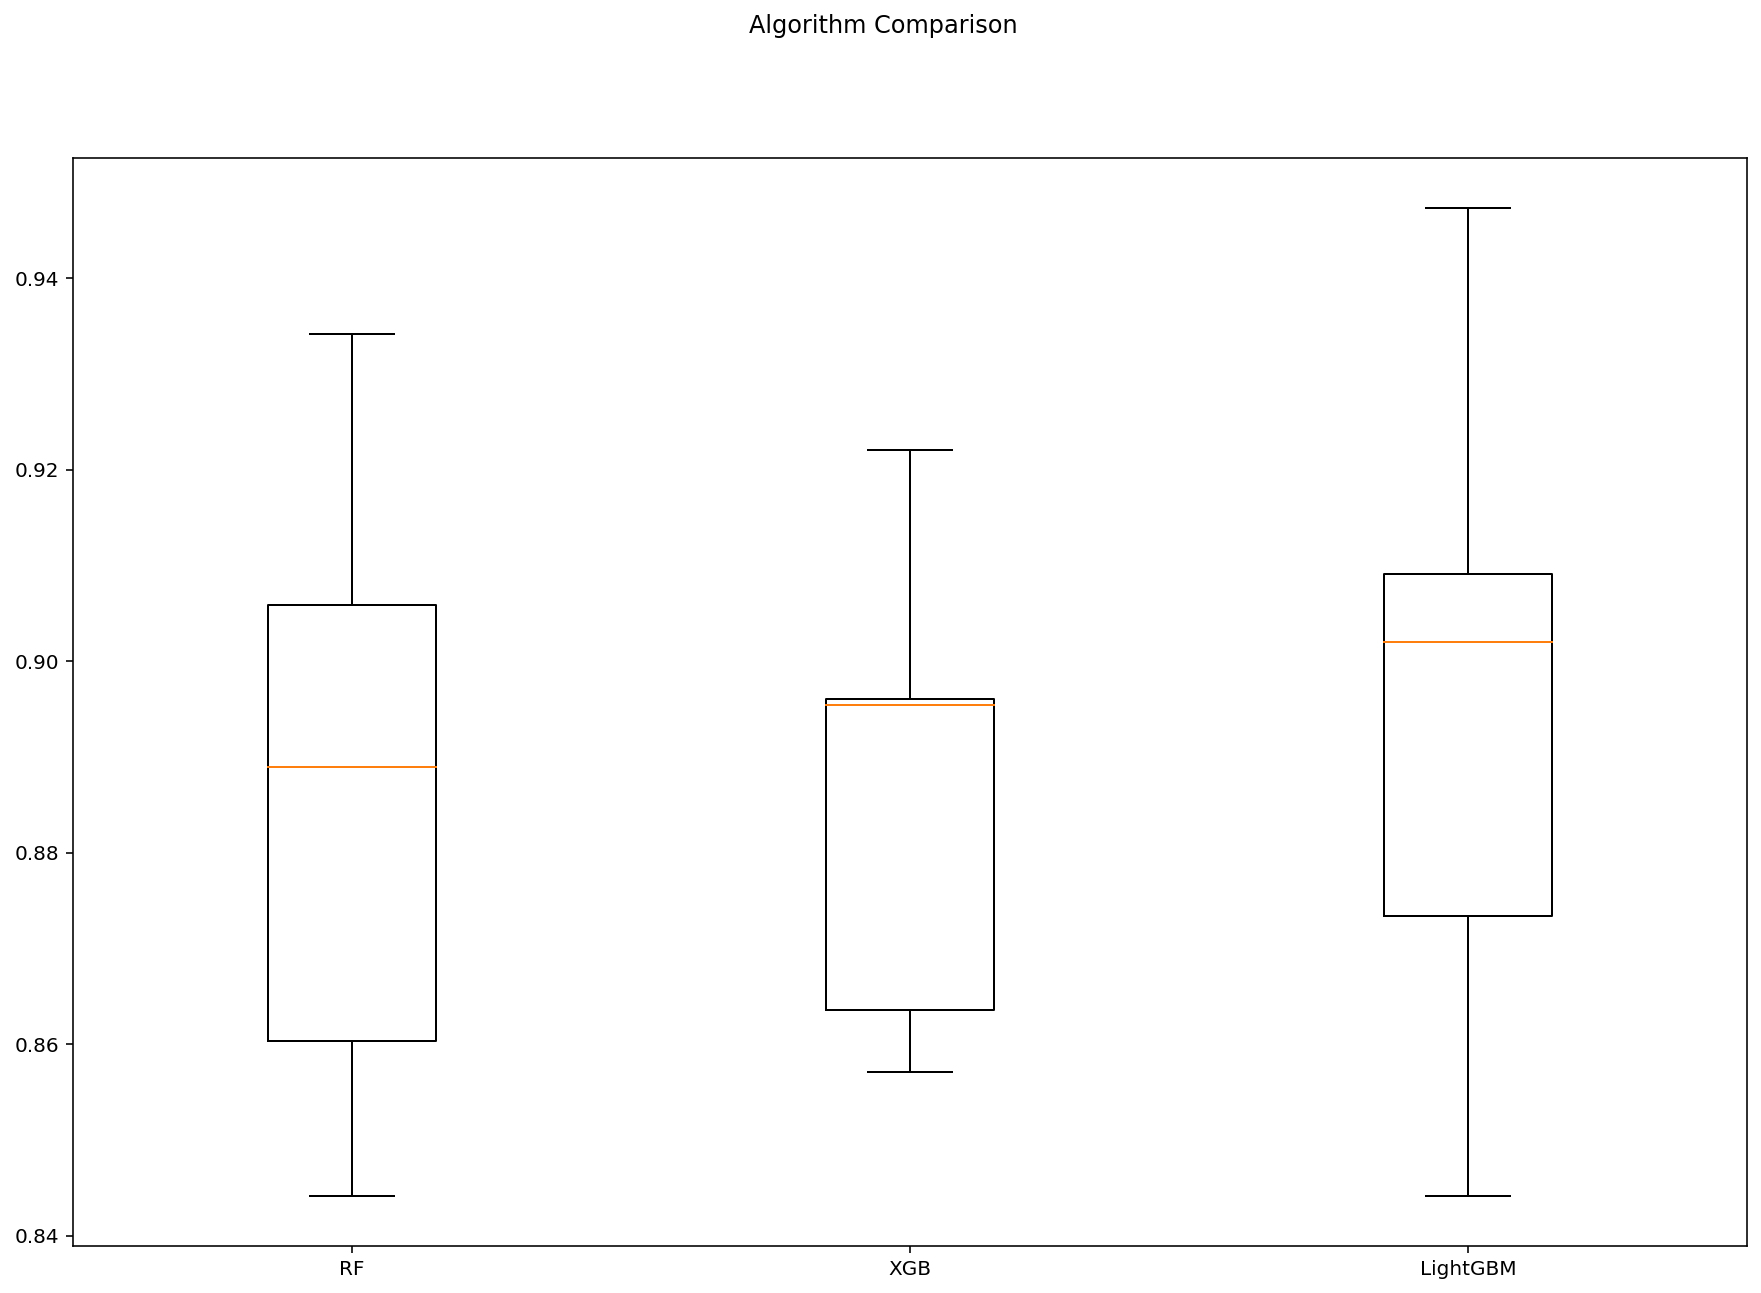

In [77]:
for name, model in models:
    
        kfold = KFold(n_splits = 10)
        cv_results = cross_val_score(model, X, y, cv = 10, scoring= "accuracy")
        results.append(cv_results)
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)
        
# boxplot algorithm comparison
fig = plt.figure(figsize=(15,10))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [78]:
models[2]

('LightGBM',
 LGBMClassifier(learning_rate=0.01, max_depth=3, n_estimators=1000,
                random_state=12345))

In [ ]:
import pickle

pickle.dump(models[2])